In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sys, getopt, os
import csv
import pickle
import copy

from tqdm import tqdm


pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

%run SodaKick_download_functions.ipynb

In [3]:
#note xgboost can handle missing values internally
#list of parameters:
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://shengyg.github.io/repository/machine%20learning/2017/02/25/Complete-Guide-to-Parameter-Tuning-xgboost.html

#custom obj functions
#https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html
#https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

In [4]:
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb
from xgboost import XGBRegressor

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from functools import partial 

from sklearn.model_selection import cross_val_score
#https://docs.ray.io/en/master/tune/tutorials/tune-xgboost.html

In [5]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss

In [6]:
from sklearn import preprocessing

    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2a.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2a.pkl', 'rb') as pk:
    out=pickle.load(pk)     
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2b.pkl', 'rb') as pk:
    inpb=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2b.pkl', 'rb') as pk:
    outb=pickle.load(pk)     

inp=np.concatenate([inp,inpb])
out=np.concatenate([out,outb])

def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])
        
NormalizeMatrix(inp)
np.nan_to_num(inp, copy=False)

normalize_mins(out)

#scaler = preprocessing.StandardScaler().fit(inp)
#inp = scaler.transform(inp)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [7]:
from typing import Tuple

def WSE(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    
    target = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    
    a=1.5
    b=.5
    
    elements = a*np.minimum(np.zeros(len(predt)),predt - target)**2+\
                      b*np.maximum(np.zeros(len(predt)),predt - target)**2
    
    return 'WSE', float(np.sqrt(np.sum(elements) / len(target)))

In [8]:
from sklearn.metrics import mean_squared_error

def train_xgb(config, col=0):
    
    train_x, test_x, train_y, test_y = train_test_split(
         inp, out[:,col], test_size=0.2)
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)  
    
    results = {}
    xgb.train(
         config,
         train_set,
         evals=[(test_set, "eval")],
         evals_result=results,
         verbose_eval=False,
         callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])
    
    error = results["eval"]["error"][-1]
    rmse = results["eval"]["rmse"][-1]
    tune.report(mean_error=error, rmse=rmse, done=True)
    
def get_best_model_checkpoint(analysis):
    best_bst = xgb.Booster()
    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    error = analysis.best_result["eval-error"]
    rmse = analysis.best_result["eval-rmse"]
    print(f"Best model parameters: {analysis.best_config}")
    print(f"Best model total error: {error:.4f}")
    print(f"Best model rmse: {rmse:.4f}")
    
    return best_bst

In [9]:
"""def train_xgb(config, col=0):
    

    x_train, x_test, y_train, y_test = train_test_split(
         inp, out[:,col], test_size=0.2)

    model=XGBRegressor(n_estimators=10,**config)
    model.fit(x_train, y_train,
        eval_set = [(x_test, y_test)],
        eval_metric = 'rmse',
        early_stopping_rounds = 5, verbose=False,
        callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])
    

    rmse=model.get_booster().best_score
    tune.report(rmse=rmse)    
    
def get_best_model_checkpoint(analysis):
    best_bst = xgb.Booster()
    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    error = analysis.best_result["rmse"]
    print(f"Best model parameters: {analysis.best_config}")
    print(f"Best model total error: {error:.4f}")
    return best_bst"""

'def train_xgb(config, col=0):\n    \n\n    x_train, x_test, y_train, y_test = train_test_split(\n         inp, out[:,col], test_size=0.2)\n\n    model=XGBRegressor(n_estimators=10,**config)\n    model.fit(x_train, y_train,\n        eval_set = [(x_test, y_test)],\n        eval_metric = \'rmse\',\n        early_stopping_rounds = 5, verbose=False,\n        callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])\n    \n\n    rmse=model.get_booster().best_score\n    tune.report(rmse=rmse)    \n    \ndef get_best_model_checkpoint(analysis):\n    best_bst = xgb.Booster()\n    best_bst.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))\n    error = analysis.best_result["rmse"]\n    print(f"Best model parameters: {analysis.best_config}")\n    print(f"Best model total error: {error:.4f}")\n    return best_bst'

In [10]:
search_space_ori = {
 "objective": "reg:pseudohubererror",
 "eval_metric": ["error"], #'gamma' : hp.uniform ('gamma', 0,0.5)
 "max_depth": tune.randint(1, 15),
 "min_child_weight": tune.choice([1, 2, 3, 4, 5]),
 "subsample": tune.uniform(0.5, 1.0),
 "eta": tune.loguniform(1e-4, 1e-1),
 "learning_rate": 1e-1, #tune.loguniform(1e-4, 1e-1),
 "colsample_bytree": tune.uniform(0.1, 0.9),
 "alpha": tune.uniform(0, 20),
 "lambda": tune.uniform(0, 10),
 "gamma" : tune.uniform (0, 1)
 }

search_space = {
 #"n_estimators": 1000,
 "objective": "reg:pseudohubererror",
 "eval_metric": ["rmse","error"], 
 "max_depth": tune.randint(1, 15),
 "min_child_weight": tune.choice([1, 2, 3, 4, 5]),
 "subsample": tune.choice(np.linspace(.5,.9,5)),
 "eta": tune.choice([1e-4, 1e-3, 1e-2, 1e-1]),
 "learning_rate": 1e-1, 
 "colsample_bytree": tune.choice(np.linspace(0,.9,10)),
 "alpha": tune.randint(0, 20),
 "lambda": tune.randint(0, 10),
 "gamma" : tune.choice(np.linspace(0,.9,10))
 }

def tune_xgb(search_space, col):
            
    # This will enable aggressive early stopping of bad trials.
    scheduler = ASHAScheduler(
        max_t=10,  # 10 training iterations
        grace_period=2,
        reduction_factor=2)

    analysis = tune.run(
        partial(train_xgb, col=col),
        metric="eval-rmse",
        mode="min",
        # You can add "gpu": 0.1 to allocate GPUs
        resources_per_trial={"cpu": 1},
        config=search_space,
        num_samples=200,
        scheduler=scheduler,
        verbose=0)

    return analysis

#analysis = tune.run(
#    train_xgb,
#    resources_per_trial={"cpu": 1},
#    config=config,
#    num_samples=100)

In [ ]:
best_bst=[]
best_cfg=[]
for i in range(8):
    print('Feature #: '+str(i))
    analysis = tune_xgb(search_space, i)
    print(analysis)
    best_cfg.append(analysis.get_best_config())
    best_cfg[-1]['file']=analysis.best_checkpoint
    best_bst.append(get_best_model_checkpoint(analysis))
    print('\n')

In [ ]:
stats=pd.concat([pd.Series(bc) for bc in best_cfg], axis=1).T
stats

In [11]:
search_space = {
 #"n_estimators": 1000,
 "objective": "reg:pseudohubererror",
 "eval_metric": ["rmse","error"], 
 "max_depth": tune.randint(1, 15),
 "min_child_weight": tune.choice([1, 2, 3, 4, 5]),
 "subsample": tune.choice(np.linspace(.5,.9,5)),
 "eta": tune.choice([1e-4, 1e-3, 1e-2, 1e-1]),
 "learning_rate": 1e-2, 
 "colsample_bytree": tune.choice(np.linspace(0,.9,10)),
 "alpha": tune.randint(0, 20),
 "lambda": tune.randint(0, 10),
 "gamma" : tune.choice(np.linspace(0,.9,10))
 }

best_bst=[]
best_cfg=[]
for i in range(8):
    print('Feature #: '+str(i))
    analysis = tune_xgb(search_space, i)
    print(analysis)
    best_cfg.append(analysis.get_best_config())
    best_cfg[-1]['file']=analysis.best_checkpoint
    best_bst.append(get_best_model_checkpoint(analysis))
    print('\n')

Feature #: 0


2021-06-01 14:45:53,538	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8266
2021-06-01 14:45:55,322	WARNING experiment.py:294 -- No name detected on trainable. Using DEFAULT.
2021-06-01 14:45:55,323	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.
2021-06-01 14:45:55,323	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-06-01 14:48:46,701	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 14:48:47,380	WARNING util.py:162 -- The `start_trial` operation took 3.472 s, which may be a performance bottleneck.
2021-06-01 14:48:51,204	WARNING util.py:162 -

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.7, 'eta': 0.001, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 5, 'lambda': 4, 'gamma': 0.4, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_14-45-55/DEFAULT_99349_00180_180_alpha=5,colsample_bytree=0.5,eta=0.001,gamma=0.4,lambda=4,max_depth=12,min_child_weight=4,subsample=0.7_2021-06-01_15-20-19/checkpoint_000005/'}
Best model total error: 0.0087
Best model rmse: 0.4396


Feature #: 1


2021-06-01 15:30:28,469	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 15:30:28,836	WARNING util.py:162 -- The `start_trial` operation took 3.648 s, which may be a performance bottleneck.
2021-06-01 15:30:33,452	WARNING util.py:162 -- The `start_trial` operation took 3.871 s, which may be a performance bottleneck.
2021-06-01 15:30:39,486	WARNING util.py:162 -- The `start_trial` operation took 6.032 s, which may be a performance bottleneck.
2021-06-01 15:30:44,890	WARNING util.py:162 -- The `start_trial` operation took 5.340 s, which may be a performance bottleneck.
2021-06-01 15:30:49,276	WARNING util.py:162 -- The `start_trial` operation took 4.148 s, which may be a performance bottleneck.
2021-06-01 15:30:52,364	WARNING util.py:162 -- The `start_trial` operation took 3.083 s, which may be a performance

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.5, 'eta': 0.0001, 'learning_rate': 0.01, 'colsample_bytree': 0.1, 'alpha': 0, 'lambda': 0, 'gamma': 0.6000000000000001, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_15-24-22/DEFAULT_f87f4_00074_74_alpha=0,colsample_bytree=0.1,eta=0.0001,gamma=0.6,lambda=0,max_depth=14,min_child_weight=1,subsample=0.5_2021-06-01_15-43-27/checkpoint_000005/'}
Best model total error: 0.0000
Best model rmse: 0.4421


Feature #: 2


2021-06-01 16:09:05,048	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 16:09:05,109	WARNING util.py:162 -- The `start_trial` operation took 0.815 s, which may be a performance bottleneck.
2021-06-01 16:09:05,877	WARNING util.py:162 -- The `start_trial` operation took 0.625 s, which may be a performance bottleneck.
2021-06-01 16:09:06,610	WARNING util.py:162 -- The `start_trial` operation took 0.731 s, which may be a performance bottleneck.
2021-06-01 16:09:07,441	WARNING util.py:162 -- The `start_trial` operation took 0.830 s, which may be a performance bottleneck.
2021-06-01 16:09:08,345	WARNING util.py:162 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.
2021-06-01 16:09:09,231	WARNING util.py:162 -- The `start_trial` operation took 0.884 s, which may be a performance

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8, 'eta': 0.0001, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 0, 'lambda': 0, 'gamma': 0.7000000000000001, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_16-05-56/DEFAULT_c7ac8_00170_170_alpha=0,colsample_bytree=0.5,eta=0.0001,gamma=0.7,lambda=0,max_depth=5,min_child_weight=4,subsample=0.8_2021-06-01_16-21-57/checkpoint_000005/'}
Best model total error: 0.0015
Best model rmse: 0.4426


Feature #: 3


2021-06-01 16:28:52,323	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 16:28:52,457	WARNING util.py:162 -- The `start_trial` operation took 1.079 s, which may be a performance bottleneck.
2021-06-01 16:28:53,736	WARNING util.py:162 -- The `start_trial` operation took 0.966 s, which may be a performance bottleneck.
2021-06-01 16:28:54,895	WARNING util.py:162 -- The `start_trial` operation took 1.146 s, which may be a performance bottleneck.
2021-06-01 16:28:55,968	WARNING util.py:162 -- The `start_trial` operation took 1.072 s, which may be a performance bottleneck.
2021-06-01 16:28:57,050	WARNING util.py:162 -- The `start_trial` operation took 1.077 s, which may be a performance bottleneck.
2021-06-01 16:28:58,296	WARNING util.py:162 -- The `start_trial` operation took 1.244 s, which may be a performance

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8, 'eta': 0.01, 'learning_rate': 0.01, 'colsample_bytree': 0.2, 'alpha': 0, 'lambda': 0, 'gamma': 0.30000000000000004, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_16-26-06/DEFAULT_9825b_00097_97_alpha=0,colsample_bytree=0.2,eta=0.01,gamma=0.3,lambda=0,max_depth=10,min_child_weight=5,subsample=0.8_2021-06-01_16-37-07/checkpoint_000005/'}
Best model total error: 0.0256
Best model rmse: 0.4482


Feature #: 4


2021-06-01 16:48:53,671	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 16:48:53,819	WARNING util.py:162 -- The `start_trial` operation took 1.097 s, which may be a performance bottleneck.
2021-06-01 16:48:55,094	WARNING util.py:162 -- The `start_trial` operation took 0.979 s, which may be a performance bottleneck.
2021-06-01 16:48:56,110	WARNING util.py:162 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.
2021-06-01 16:48:57,512	WARNING util.py:162 -- The `start_trial` operation took 1.400 s, which may be a performance bottleneck.
2021-06-01 16:48:58,943	WARNING util.py:162 -- The `start_trial` operation took 1.430 s, which may be a performance bottleneck.
2021-06-01 16:49:00,384	WARNING util.py:162 -- The `start_trial` operation took 1.438 s, which may be a performance

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9, 'eta': 0.1, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'alpha': 0, 'lambda': 4, 'gamma': 0.1, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_16-47-34/DEFAULT_98125_00171_171_alpha=0,colsample_bytree=0.4,eta=0.1,gamma=0.1,lambda=4,max_depth=4,min_child_weight=3,subsample=0.9_2021-06-01_17-05-35/checkpoint_000005/'}
Best model total error: 0.0007
Best model rmse: 0.4424


Feature #: 5


2021-06-01 17:11:06,934	WARNING util.py:162 -- The `start_trial` operation took 0.781 s, which may be a performance bottleneck.
2021-06-01 17:11:07,367	WARNING worker.py:1115 -- A worker died or was killed while executing task b6eedcdd21e1f958ffffffffffffffffffffffff01000000.
2021-06-01 17:11:08,964	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 17:11:09,137	WARNING util.py:162 -- The `start_trial` operation took 1.678 s, which may be a performance bottleneck.
2021-06-01 17:11:10,474	WARNING util.py:162 -- The `start_trial` operation took 1.335 s, which may be a performance bottleneck.
2021-06-01 17:11:12,034	WARNING util.py:162 -- The `start_trial` operation took 1.558 s, which may be a performance bottleneck.
2021-06-01 17:11:13,530	WARNING util.py:162 -- The `start_trial` operation took 1.494 s, which

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'eta': 0.1, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'alpha': 0, 'lambda': 0, 'gamma': 0.0, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_17-08-31/DEFAULT_85611_00118_118_alpha=0,colsample_bytree=0.9,eta=0.1,gamma=0.0,lambda=0,max_depth=6,min_child_weight=3,subsample=0.9_2021-06-01_17-21-36/checkpoint_000005/'}
Best model total error: 0.0029
Best model rmse: 0.4426


Feature #: 6


2021-06-01 17:32:07,851	WARNING util.py:162 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.
2021-06-01 17:32:09,578	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 17:32:09,763	WARNING util.py:162 -- The `start_trial` operation took 1.508 s, which may be a performance bottleneck.
2021-06-01 17:32:10,916	WARNING util.py:162 -- The `start_trial` operation took 1.151 s, which may be a performance bottleneck.
2021-06-01 17:32:12,213	WARNING util.py:162 -- The `start_trial` operation took 1.285 s, which may be a performance bottleneck.
2021-06-01 17:32:13,534	WARNING util.py:162 -- The `start_trial` operation took 1.308 s, which may be a performance bottleneck.
2021-06-01 17:32:15,499	WARNING util.py:162 -- The `start_trial` operation took 1.953 s, which may be a performance

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.6, 'eta': 0.01, 'learning_rate': 0.01, 'colsample_bytree': 0.6000000000000001, 'alpha': 0, 'lambda': 8, 'gamma': 0.30000000000000004, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_17-29-57/DEFAULT_83d06_00189_189_alpha=0,colsample_bytree=0.6,eta=0.01,gamma=0.3,lambda=8,max_depth=12,min_child_weight=5,subsample=0.6_2021-06-01_17-54-27/checkpoint_000005/'}
Best model total error: -0.2738
Best model rmse: 1.2626


Feature #: 7


2021-06-01 17:59:25,717	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 84670477 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-06-01 17:59:25,860	WARNING util.py:162 -- The `start_trial` operation took 1.370 s, which may be a performance bottleneck.
2021-06-01 17:59:27,599	WARNING util.py:162 -- The `start_trial` operation took 1.360 s, which may be a performance bottleneck.
2021-06-01 17:59:29,094	WARNING util.py:162 -- The `start_trial` operation took 1.487 s, which may be a performance bottleneck.
2021-06-01 17:59:30,787	WARNING util.py:162 -- The `start_trial` operation took 1.691 s, which may be a performance bottleneck.
2021-06-01 17:59:32,504	WARNING util.py:162 -- The `start_trial` operation took 1.715 s, which may be a performance bottleneck.
2021-06-01 17:59:34,200	WARNING util.py:162 -- The `start_trial` operation took 1.685 s, which may be a performance

Best model parameters: {'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.8, 'eta': 0.001, 'learning_rate': 0.01, 'colsample_bytree': 0.6000000000000001, 'alpha': 7, 'lambda': 0, 'gamma': 0.7000000000000001, 'file': '/Users/federico comitani/ray_results/DEFAULT_2021-06-01_17-56-19/DEFAULT_33001_00055_55_alpha=7,colsample_bytree=0.6,eta=0.001,gamma=0.7,lambda=0,max_depth=14,min_child_weight=2,subsample=0.8_2021-06-01_18-05-01/checkpoint_000005/'}
Best model total error: -1.5681
Best model rmse: 2.3016




In [ ]:
stats=pd.concat([pd.Series(bc) for bc in best_cfg], axis=1).T
stats

# now train each model

In [129]:
from sklearn.model_selection import KFold

def runKfold(indata, outdata, num, best_cfg=best_cfg):
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(indata)
    
    tmpparms = best_cfg[num]
    tmpparms.pop("file", None)    

    es = xgb.callback.EarlyStopping(
    rounds=3,
    #abs_tol=1e-4, not available yet (1.5)
    save_best=True,
    maximize=False,
    #data_name="validation_0",
    metric_name="error",
    )
    
    for train_index, test_index in kf.split(indata):        
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]

        model = MultiOutputRegressor(
            XGBRegressor(**tmpparms))
        
        eval_set = [(x_test, y_test[:,i::8])]
        model.fit(x_train, y_train[:,i::8], eval_metric="error", eval_set=eval_set, callbacks=[es])
        
        print(model.best_score, model.best_iteration)
        
        ec.append(model.best_iteration)
        losses.append(model.best_score)
        
        pred=model.predict(x_test, iteration_range=(0, bst.best_iteration))
    
    print('Num: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    #print('MSE Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in mss]),np.std([np.mean(x) for x in mss])))
    return model

In [130]:
for i in range(8):
    runKfold(inp, out, i, best_cfg)

//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


AssertionError: 

# K fold on single column because why not

In [13]:
from sklearn.model_selection import KFold

def runKfold(indata, outdata, num, best_cfg=best_cfg):
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(indata)
    
    tmpparms = best_cfg[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=500
    print(tmpparms)
        
    ec,losses, errors = [], [], []
    results=[]
    
    for train_index, test_index in kf.split(indata):        
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]

        train_set = xgb.DMatrix(x_train, label=y_train[:,i])
        test_set = xgb.DMatrix(x_test, label=y_test[:,i])
    
        model=XGBRegressor(**tmpparms)
        model.fit(x_train, y_train[:,i],
            eval_set = [(x_train, y_train[:,i]),(x_test, y_test[:,i])],
            eval_metric = 'rmse',
            early_stopping_rounds = 5, verbose=False)
        
        results.append(model.evals_result())
        best_iteration = model.get_booster().best_ntree_limit
        
        pred = model.predict(x_test, ntree_limit=best_iteration)

        ec.append(model.best_iteration)
        losses.append(model.get_booster().best_score)
        errors.append(np.mean(pred-y_test[:,i]))
    
    print('Num: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    print('Error Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in errors]),np.std([np.mean(x) for x in errors])))

     
        
    # plot log loss
    fig, ax = plt.subplots()
    for rs in results:
        ax.plot(range(len(rs['validation_0']['rmse'])), rs['validation_0']['rmse'], label='Train', color='blue')
        ax.plot(range(len(rs['validation_0']['rmse'])), rs['validation_1']['rmse'], label='Test', color='orange')
    plt.show()
    
    #print('MSE Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in mss]),np.std([np.mean(x) for x in mss])))

Feature #: 0
{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.7, 'eta': 0.001, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 5, 'lambda': 4, 'gamma': 0.4, 'n_estimators': 500}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Num: 499.000+/-0.000
KFold Result: 0.047+/-0.003
Error Result: -0.004+/-0.001


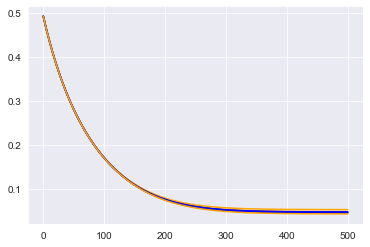


Feature #: 1
{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.5, 'eta': 0.0001, 'learning_rate': 0.01, 'colsample_bytree': 0.1, 'alpha': 0, 'lambda': 0, 'gamma': 0.6000000000000001, 'n_estimators': 500}
Num: 499.000+/-0.000
KFold Result: 0.011+/-0.014
Error Result: 0.003+/-0.001


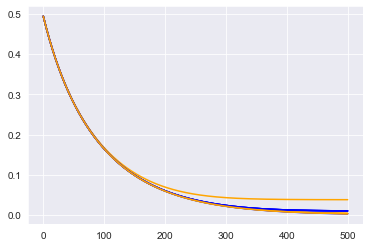


Feature #: 2
{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8, 'eta': 0.0001, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 0, 'lambda': 0, 'gamma': 0.7000000000000001, 'n_estimators': 500}
Num: 474.800+/-44.508
KFold Result: 0.047+/-0.014
Error Result: 0.004+/-0.004


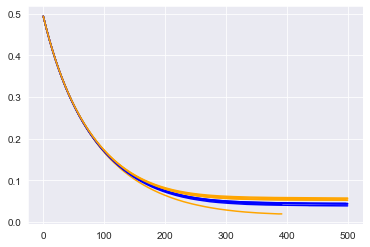


Feature #: 3
{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8, 'eta': 0.01, 'learning_rate': 0.01, 'colsample_bytree': 0.2, 'alpha': 0, 'lambda': 0, 'gamma': 0.30000000000000004, 'n_estimators': 500}
Num: 499.000+/-0.000
KFold Result: 0.132+/-0.007
Error Result: 0.001+/-0.001


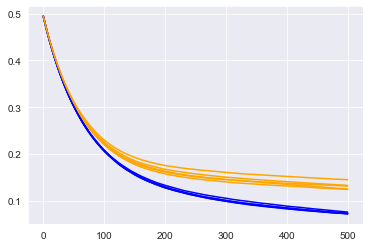


Feature #: 4
{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9, 'eta': 0.1, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'alpha': 0, 'lambda': 4, 'gamma': 0.1, 'n_estimators': 500}
Num: 498.800+/-0.400
KFold Result: 0.034+/-0.013
Error Result: 0.003+/-0.001


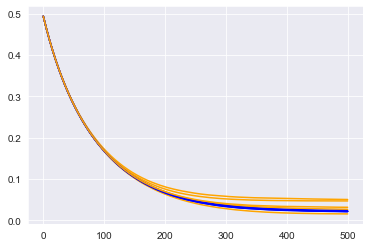


Feature #: 5
{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9, 'eta': 0.1, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'alpha': 0, 'lambda': 0, 'gamma': 0.0, 'n_estimators': 500}
Num: 499.000+/-0.000
KFold Result: 0.033+/-0.011
Error Result: 0.003+/-0.001


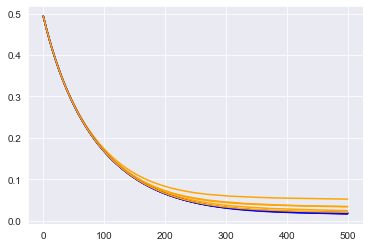


Feature #: 6
{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.6, 'eta': 0.01, 'learning_rate': 0.01, 'colsample_bytree': 0.6000000000000001, 'alpha': 0, 'lambda': 8, 'gamma': 0.30000000000000004, 'n_estimators': 500}


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-9ba6afe38ef0>", line 3, in <module>
    runKfold(inp, out, i, best_cfg)
  File "<ipython-input-13-bcbab07eba43>", line 26, in runKfold
    early_stopping_rounds = 5, verbose=False)
  File "//miniconda3/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "//miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "//miniconda3/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "//miniconda3/lib/python3.7/site-packages/xgboost/training.py", line 102, in _train_internal
    bst.update(dtrain, i, obj)
  File "//miniconda3/lib/python3.7/site-packages/xgboost/core.py", line 1282, in update
    dtrain.handl

TypeError: object of type 'NoneType' has no len()

In [14]:
for i in range(8):
    print('Feature #: '+str(i))
    runKfold(inp, out, i, best_cfg)
    print()

# Now train as multioutput

In [317]:
from sklearn.multioutput import MultiOutputRegressor

x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.20, random_state=32)

models=[]
for num in range(8):
    
    tmpparms = best_cfg[num]
    tmpparms.pop("file", None)    
    tmpparms['n_estimators']=300
    print(tmpparms)
    
    models.append(MultiOutputRegressor(
        XGBRegressor(**tmpparms)))
    models[-1].fit(x_train, y_train[:,num::8])

{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9, 'eta': 0.001, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'alpha': 7, 'lambda': 1, 'gamma': 0.6000000000000001, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.9, 'eta': 0.1, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'alpha': 11, 'lambda': 3, 'gamma': 0.7000000000000001, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.8, 'eta': 0.001, 'learning_rate': 0.01, 'colsample_bytree': 0.0, 'alpha': 6, 'lambda': 0, 'gamma': 0.0, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 13, 'min_child_weight': 3, 'subsample': 0.8, 'eta': 0.01, 'learning_rate': 0.01, 'colsample_bytree': 0.7000000000000001, 'alpha': 8, 'lambda': 7, 'gamma': 0.7000000000000001, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5, 'eta': 0.01, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'alpha': 2, 'lambda': 4, 'gamma': 0.6000000000000001, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.9, 'eta': 0.01, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'alpha': 0, 'lambda': 9, 'gamma': 0.5, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.5, 'eta': 0.001, 'learning_rate': 0.01, 'colsample_bytree': 0.7000000000000001, 'alpha': 3, 'lambda': 2, 'gamma': 0.2, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'objective': 'reg:pseudohubererror', 'eval_metric': ['rmse', 'error'], 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.7, 'eta': 0.0001, 'learning_rate': 0.01, 'colsample_bytree': 0.30000000000000004, 'alpha': 12, 'lambda': 2, 'gamma': 0.1, 'n_estimators': 300}


//miniconda3/lib/python3.7/site-packages/xgboost/data.py:106: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [321]:
def multiprediction(inpt, models):
    
    preds=[]
    for model in models:
        preds.append(model.predict(inpt))

    preds = np.array(preds)   
    preds = np.resize(preds, (preds.shape[1], preds.shape[2]*preds.shape[0]))
    
    rearranged=[]
    for i in range(8):
        for j in range(50):
            rearranged.append(i+8*j)
        
    return preds[:,rearranged]

In [322]:
y_pred = multiprediction(x_test, models)

In [323]:
from sklearn.metrics import mean_squared_error as mse
mse(y_pred,y_test)

0.21990882539911286

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 1, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97, 105, 113, 121, 129, 137, 145, 153, 161, 169, 177, 185, 193, 201, 209, 217, 225, 233, 241, 249, 257, 265, 273, 281, 289, 297, 305, 313, 321, 329, 337, 345, 353, 361, 369, 377, 385, 393, 2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146, 154, 162, 170, 178, 186, 194, 202, 210, 218, 226, 234, 242, 250, 258, 266, 274, 282, 290, 298, 306, 314, 322, 330, 338, 346, 354, 362, 370, 378, 386, 394, 3, 11, 19, 27, 35, 43, 51, 59, 67, 75, 83, 91, 99, 107, 115, 123, 131, 139, 147, 155, 163, 171, 179, 187, 195, 203, 211, 219, 227, 235, 243, 251, 259, 267, 275, 283, 291, 299, 307, 315, 323, 331, 339, 347, 355, 363, 371, 379, 387, 395, 4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100, 108, 

(1, 400)

In [ ]:
     results.append(model.evals_result())
        best_iteration = model.get_booster().best_ntree_limit
        

        ec.append(model.best_iteration)
        losses.append(model.get_booster().best_score)
        errors.append(np.mean(pred-y_test[:,i]))
    
    print('Num: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    print('Error Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in errors]),np.std([np.mean(x) for x in errors])))

     
        
    # plot log loss
    fig, ax = plt.subplots()
    for rs in results:
        ax.plot(range(len(rs['validation_0']['rmse'])), rs['validation_0']['rmse'], label='Train', color='blue')
        ax.plot(range(len(rs['validation_0']['rmse'])), rs['validation_1']['rmse'], label='Test', color='orange')
    plt.show()

# Manual inspection

In [132]:
pred=model.predict(inp)

In [113]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))

print((out[1]-out[10]).sum())
print((out[50]-out[60]).sum())
print((out[100]-out[110]).sum())

Baseline WSE: 0.230
Baseline WSE l1: 0.139
Baseline MSE: 0.153
Baseline MSE l1: 0.092
-18.0
16.566666666666666
2.0000000000000004


In [ ]:
print('Baseline WSE: {:.3f}'.format(WSE2(pred[0],out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(pred[0],out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(pred[0],out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(pred[0],out[0], a=1, b=1)))

print((pred[1]-pred[10]).sum())
print((pred[50]-pred[60]).sum())
print((pred[100]-pred[110]).sum())

In [ ]:
cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

reframe, byteamframe = revert_output(pred[0])
print(byteamframe)
reframe, byteamframe = revert_output(out[0])
print(byteamframe)